In [1]:
# import packages
import pandas as pd
import os
import csv
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.models import ldaseqmodel
import time
from gensim.models.wrappers import DtmModel
import pickle
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
# construct the stop word list
stopwords = [line.strip() for line in open("stop_words_copy2.txt",encoding='UTF-8').readlines()]

In [3]:
# read in csv file
all_data = pd.read_csv('./all_data.csv', header=None)
# add columns
all_data.columns = ["year", "title", "article"]
# sort by year
all_data = all_data.sort_values(by=['year'])
# change index
new_index = np.arange(0, len(all_data))
all_data["new_index"] = new_index
all_data = all_data.set_index('new_index')

In [4]:
# construct the function that preprocess the text
def preprocess(text):
    '''
    Preprocess the text by tokenizing the string into uni-grams, deleting all 
    numbers, punctuations and stop words. Store the preprocessed sting into 
    a list of words
    
    input: 
        text: text for preprocessing(str)
    output: a list of words
    '''
    result = []
    tokens = gensim.utils.tokenize(text)
    tokens_lst = list(tokens)
    for token in tokens_lst:
        if token not in stopwords:
            result.append(token)
            
    return result

In [5]:
# preprocess the data
processed_df = all_data['article'].map(preprocess)

In [6]:
# prepare Document-Term Matrix for the DTA model 
# Create Dictionaries for unique word counts of each decade
dic_all = corpora.Dictionary(processed_df)

# Create Corpus: Term Document Frequency
corpus_all = [dic_all.doc2bow(text) for text in processed_df]

In [7]:
# set the time slice
all_data[all_data['year']==1958]
# before 60s: 0-35
all_data[all_data['year']==1978]
# before 1979: 36-70
all_data[all_data['year']==1989]
# before 1990: 71-876
all_data[all_data['year']==2003]
# before 2003: 877-1811
time_slice = [71, 806, 935]

In [28]:
# fit the 8-topic model
start = time.time()
ldaseq_8 = ldaseqmodel.LdaSeqModel(corpus=corpus_all, id2word=dic_all, time_slice=time_slice, 
                                    num_topics=8, chain_variance=0.1, random_state=100)
end = time.time()
print(end - start)

/Users/ditong/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


9114.88179397583


In [29]:
# save model
pickle.dump(ldaseq_8, open("ldaseq_model_8_v2.sav", 'wb'))
# check
loaded_model_8_v2 = pickle.load(open("ldaseq_model_8_v2.sav", 'rb'))

In [44]:
# calculate coherence matrix
topics_dtm_8 = ldaseq_8.dtm_coherence(time=2)
cm_DTM_8 = CoherenceModel(topics=topics_dtm_8, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM_8.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.1286581221196814


In [34]:
doc_topic_8 = []
for doc_num in range(len(all_data)):
    doc = loaded_model_8_v2.doc_topics(doc_num)
    doc_topic_8.append(doc)
topic_df_8 = pd.DataFrame(doc_topic_8, columns=['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8'])
topic_com_df_8 = pd.concat([all_data, topic_df_8], axis=1, sort=False)
grouped_df_8 = topic_com_df_8.groupby(['year']).sum().reset_index()

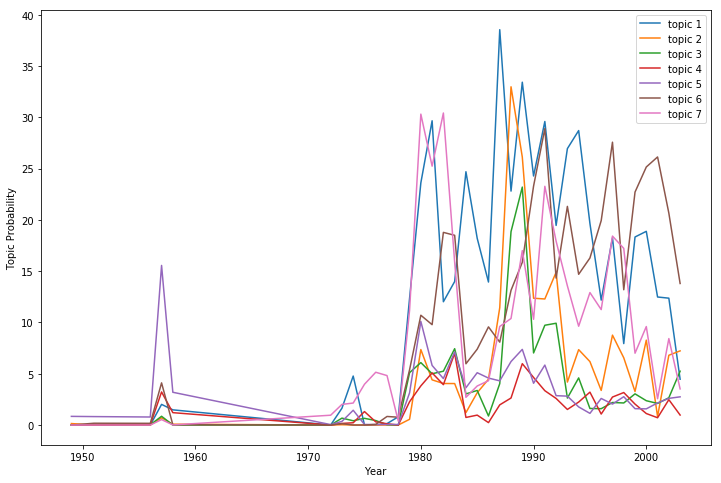

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(grouped_df_8['year'], grouped_df_8['t1'], label='topic 1')
plt.plot(grouped_df_8['year'], grouped_df_8['t2'], label='topic 2')
plt.plot(grouped_df_8['year'], grouped_df_8['t3'], label='topic 3')
plt.plot(grouped_df_8['year'], grouped_df_8['t4'], label='topic 4')
plt.plot(grouped_df_8['year'], grouped_df_8['t5'], label='topic 5')
plt.plot(grouped_df_8['year'], grouped_df_8['t6'], label='topic 6')
plt.plot(grouped_df_8['year'], grouped_df_8['t7'], label='topic 7')
plt.xlabel("Year")
plt.ylabel("Topic Probability")
plt.legend(loc='best')
plt.show()

In [35]:
# print topic evolution
# evolution of 1st topic
first_topic = ldaseq_8.print_topic_times(topic=0) 
first_topic

[[('人口', 0.06601663885918738),
  ('世界', 0.026366620169194332),
  ('会议', 0.02611732921201719),
  ('国家', 0.023522347025244514),
  ('问题', 0.01805530364546204),
  ('代表', 0.016850720612247322),
  ('政策', 0.01449218515144634),
  ('人民', 0.012385275405403039),
  ('经济', 0.011953065812531428),
  ('国际', 0.010940936642755405),
  ('发展', 0.01079651689814937),
  ('指出', 0.010732681168022956),
  ('中国', 0.010582835002416234),
  ('增长', 0.010260314034909117),
  ('各国', 0.0100860035618222),
  ('联合国', 0.007865477025302974),
  ('代表团', 0.007761229687109919),
  ('第三世界', 0.006994979914462512),
  ('发言', 0.006968477577189352),
  ('次', 0.005987789042476511)],
 [('人口', 0.07438181362249657),
  ('中国', 0.025187707504629946),
  ('世界', 0.01661597062000949),
  ('发展', 0.0159527920245607),
  ('国家', 0.014386763409775502),
  ('问题', 0.013218310535234078),
  ('计划生育', 0.013037875485358896),
  ('会议', 0.011746661042067657),
  ('政策', 0.010930240336275246),
  ('联合国', 0.010860424886965344),
  ('亚洲', 0.010057683261585251),
  ('国际', 0.0

In [36]:
# evolution of 2nd topic
second_topic = ldaseq_8.print_topic_times(topic=1) 
second_topic

[[('计划生育', 0.016820619647012643),
  ('人口', 0.01595616848847828),
  ('工作', 0.013995810177259966),
  ('人', 0.01309294862460604),
  ('生育', 0.011936570986200141),
  ('管理', 0.008463356521162509),
  ('万', 0.0076095842366648795),
  ('部门', 0.007417005473832738),
  ('出生', 0.007166510398542559),
  ('流动', 0.006895136912963988),
  ('计划', 0.006612772938473451),
  ('干部', 0.006582595585593584),
  ('超生', 0.0059214093839871145),
  ('统计', 0.005337961683561033),
  ('调查', 0.0051820244405098815),
  ('胎', 0.005163328984895562),
  ('外', 0.005093345742888364),
  ('人员', 0.004829301421135359),
  ('登记', 0.004761628488704905),
  ('文化', 0.004224067610497891)],
 [('计划生育', 0.02782521230909709),
  ('人口', 0.01562857299899487),
  ('生育', 0.01364035836149552),
  ('工作', 0.012918992640685778),
  ('人', 0.01225701909841508),
  ('管理', 0.008230183413650151),
  ('流动', 0.0080356331668576),
  ('超生', 0.007486864321894813),
  ('万', 0.006970832624192755),
  ('部门', 0.006443048268928145),
  ('出生', 0.006332844381701909),
  ('干部', 0.006

In [37]:
# evolution of 3rd topic
second_topic = ldaseq_8.print_topic_times(topic=2) 
second_topic

[[('手术', 0.02331696514112304),
  ('生', 0.020337333839530094),
  ('孩子', 0.01862100814218547),
  ('人', 0.014404400519945921),
  ('计划生育', 0.010355755175055542),
  ('大队', 0.007766187751069891),
  ('实行', 0.007192254150277841),
  ('群众', 0.006883435593797904),
  ('夫妇', 0.00663315827112576),
  ('家庭', 0.005979004225816256),
  ('元', 0.005853321671939788),
  ('思想', 0.005845713458598639),
  ('工作', 0.005774055304807167),
  ('生活', 0.005597956615179195),
  ('生育', 0.005371521991061173),
  ('胎', 0.005185741250837566),
  ('农村', 0.0050491774795892105),
  ('问题', 0.004676182145364264),
  ('女', 0.004512363218850331),
  ('少', 0.00448195369355413)],
 [('生', 0.02475022588382018),
  ('孩子', 0.023353275576415426),
  ('人', 0.012984106271831301),
  ('计划生育', 0.011549854389376958),
  ('夫妇', 0.00952618609801377),
  ('元', 0.008407770446331496),
  ('胎', 0.008407320962972285),
  ('群众', 0.007678672010134064),
  ('农村', 0.007355213426812964),
  ('工作', 0.00650278330125009),
  ('农民', 0.006016852410650288),
  ('生育', 0.00584261

In [38]:
# evolution of 4th topic
second_topic = ldaseq_8.print_topic_times(topic=3) 
second_topic

[[('妇女', 0.025547752507552538),
  ('人', 0.024920453903976066),
  ('职工', 0.015435210431595474),
  ('女工', 0.010173738559324371),
  ('女', 0.009079859011194846),
  ('参加', 0.008483691487478972),
  ('孩子', 0.00826485474187176),
  ('元', 0.008126931459662779),
  ('厂', 0.008084330343255057),
  ('生活', 0.007830652873823627),
  ('生育', 0.007236768793201658),
  ('住', 0.006777967281705284),
  ('学习', 0.006385989648267594),
  ('劳动', 0.006087571534189114),
  ('生', 0.005897891273847301),
  ('社员', 0.005748974132137028),
  ('生产', 0.005590014632079666),
  ('岁', 0.005276589454560083),
  ('计划生育', 0.004476781713166197),
  ('好处', 0.0044481818106076225)],
 [('人', 0.015848893703595136),
  ('妇女', 0.015125437380027362),
  ('计划生育', 0.010059198134832512),
  ('岁', 0.009962511105028994),
  ('职工', 0.009609406226865631),
  ('女', 0.008101652936466603),
  ('元', 0.007620186101673068),
  ('工作', 0.006245466954258143),
  ('孩子', 0.005810042078015343),
  ('生', 0.0050503746019483),
  ('村', 0.004953689654627637),
  ('厂', 0.00488457

In [39]:
# evolution of 5th topic
second_topic = ldaseq_8.print_topic_times(topic=4) 
second_topic

[[('避孕', 0.02013463064696693),
  ('生育', 0.011084250645021564),
  ('节育', 0.010455004884316717),
  ('工作', 0.009760562089128403),
  ('人', 0.008738468686145535),
  ('方法', 0.007317682503510418),
  ('宣传', 0.006943953007749788),
  ('人工流产', 0.005749239023099597),
  ('问题', 0.005681951776797622),
  ('健康', 0.005570649060517349),
  ('手术', 0.005473457163007265),
  ('节制', 0.005380429497178681),
  ('进行', 0.005342166721185867),
  ('研究', 0.005331131023735525),
  ('卫生', 0.005205106044844059),
  ('妇女', 0.0051846564071622615),
  ('技术', 0.005026027206448995),
  ('人民', 0.00463335446233091),
  ('指导', 0.0046203442617850565),
  ('国家', 0.004531811347926998)],
 [('节育', 0.018851096426206203),
  ('计划生育', 0.015106741028781342),
  ('手术', 0.015059760492072777),
  ('避孕', 0.014902360094792757),
  ('技术', 0.011630974547773716),
  ('研究', 0.009952594576093802),
  ('妇女', 0.007522262410886093),
  ('卫生', 0.007144833825230254),
  ('方法', 0.005686003767469039),
  ('人员', 0.005558413361069252),
  ('医院', 0.0054424313766025315),
  (

In [40]:
# evolution of 6th topic
second_topic = ldaseq_8.print_topic_times(topic=5) 
second_topic

[[('工作', 0.05031821834164956),
  ('宣传', 0.021138560767599086),
  ('计划生育', 0.02088101331383202),
  ('群众', 0.02086253319965991),
  ('社会主义', 0.016751532503678345),
  ('全国', 0.014434431198580979),
  ('人口', 0.014406193160134476),
  ('人民', 0.010590154959181735),
  ('我国', 0.009169999254902058),
  ('计划', 0.00886036883895198),
  ('建设', 0.008403221676879992),
  ('生育', 0.007910276459680824),
  ('增长', 0.0075400976079955905),
  ('各级', 0.007290505753791885),
  ('必须', 0.006831944159586755),
  ('控制', 0.006822810707770945),
  ('发展', 0.006234440185526121),
  ('要求', 0.006143279121873037),
  ('进一步', 0.006125715824525371),
  ('国家', 0.00598435525329419)],
 [('计划生育', 0.05440675342763169),
  ('工作', 0.04012491388626668),
  ('人口', 0.014852156795886546),
  ('全国', 0.012616137530573314),
  ('我国', 0.012580561969191058),
  ('群众', 0.0115552773640217),
  ('控制', 0.010882384013495693),
  ('宣传', 0.010645094406464618),
  ('生育', 0.009110004629358206),
  ('政策', 0.008459641869844294),
  ('人民', 0.0067820717831693625),
  ('国家'

In [41]:
# evolution of 7th topic
second_topic = ldaseq_8.print_topic_times(topic=6) 
second_topic

[[('计划生育', 0.05078694577884471),
  ('工作', 0.037755073226736824),
  ('思想', 0.009684450525932475),
  ('晚婚', 0.00891890142405399),
  ('领导', 0.008238131324191015),
  ('群众', 0.008172367618994699),
  ('实行', 0.0073150510376956655),
  ('主席', 0.0068410107235343355),
  ('人口', 0.006833431196682804),
  ('革命', 0.0065660207307343815),
  ('开展', 0.0065124238090567815),
  ('宣传', 0.0064066526000061625),
  ('抓', 0.006253775490712183),
  ('计划', 0.005894253720169742),
  ('措施', 0.005865610628356017),
  ('干部', 0.0058226153867882895),
  ('青年', 0.005809168870870755),
  ('公社', 0.005613040615871399),
  ('大队', 0.0056006476146506995),
  ('新', 0.005473505833172563)],
 [('计划生育', 0.042695908109592055),
  ('工作', 0.02779332499834596),
  ('人口', 0.014268967952507218),
  ('干部', 0.011416061796432949),
  ('群众', 0.009311471293479602),
  ('教育', 0.008971561220133276),
  ('夫妇', 0.00842852475376169),
  ('措施', 0.007898659324620576),
  ('抓', 0.007258035505381992),
  ('生产', 0.007203009975749259),
  ('县', 0.0070566655767374566),
  (

In [42]:
# evolution of 7th topic
second_topic = ldaseq_8.print_topic_times(topic=7) 
second_topic

[[('人口', 0.032103134817583895),
  ('我国', 0.013795554371975122),
  ('问题', 0.012531282270373282),
  ('人', 0.011774470103397987),
  ('生产', 0.011102107353010439),
  ('发展', 0.009596607960269041),
  ('增加', 0.0089698096653174),
  ('人民', 0.007547889957097444),
  ('农业', 0.006618300135741255),
  ('增长', 0.006473859045225658),
  ('工业', 0.005729544994180195),
  ('社会主义', 0.005610490050535014),
  ('平均', 0.005353733488867962),
  ('新', 0.005143750580028393),
  ('建设', 0.00511134780482078),
  ('社会', 0.00497470199981362),
  ('每年', 0.0049306061470379536),
  ('提高', 0.004924887757681413),
  ('国家', 0.004861932486706145),
  ('经济', 0.00480097059919532)],
 [('人口', 0.06643926487838447),
  ('增长', 0.021232471037731123),
  ('我国', 0.013838556461788179),
  ('发展', 0.012397113307034928),
  ('人', 0.01124881382726492),
  ('控制', 0.008710332246946072),
  ('问题', 0.00870481968384061),
  ('经济', 0.008656079019682121),
  ('增加', 0.008421761020877189),
  ('亿', 0.007427798358789421),
  ('平均', 0.0071585595863238715),
  ('生产', 0.0066